In [1]:
import numpy as np
import pandas as pd

from scipy import stats, special, spatial
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import warnings
warnings.filterwarnings('ignore')

import subprocess, os
import argparse
import itertools
import time

# https://github.com/jnothman/UpSetPlot
import upsetplot

In [2]:
## datasets
folder = '../data/'

# Dataset
# data relevance
fn0 = 'scerevisiae_tpm_full_cut5.csv'
fn1 = 'relevance_rsd1_lmbda022_w10.reg_cf'
fn2 = 'relevance_rsd1_lmbda022_w10.regions'
fn3 = 'scerevisiae.rsd1.lmbda_22.npz'

# Dataset
# Relevance cluster information
fn4 = 'consensus_gene_clusters_4.csv'

# Dataset
# Tomtom results
fn5 = 'tomtom_databases.csv'
fn6 = 'tomtom_pairwise.csv'
fn7 = 'df_motif_seq_id.csv'

# Dataset
# PWM counts jaspar format 1 and 2
fn8 = 'pwms_z2_08_k4_c6_ungapped_trimmed_02.jaspar'
fn9 = 'pwms_z2_08_k4_c6_ungapped_trimmed_02-special.jaspar'

# Dataset
# sequences, motifs, rules dframes 
fn10 = 'seqs_z2_08_k4_c6.csv'
fn11 = 'motifs_z2_08_k4_c6.csv'
fn12 = 'rules_z2_08_k4_c6_s3_c001.csv'
fn13 = 'motifs_rsd1_lmbda022_w10_z2'

# Dataset
# nucleosomes and enrichments
fn14 = 'scerevisiae.rsd1.saga'
fn15 = '2008_Tirosh_opn_dpn_parsed.csv'
fn16 = '2016_Zhang_srep33970-s3.xls'

In [3]:
# def variables
names = ['0_promoter','1_5UTR','2_3UTR','3_terminator']
names_plot = ['Promoter','5UTR','3UTR','Terminator']
limits = np.array([[0,1000],[1000,1300],[1300,1650],[1650,2150]])
label_names =["0_none", "1_low", "2_medium", "3_high"]
window = 10
lmbda = 0.22

In [4]:
# function definitions

def boxtpm(x, lmbda):
    return special.inv_boxcox(x, lmbda)

def zscore(x):
    x = np.transpose(x)
    #z = stats.zscores(x)
    z = (x-np.mean(x,axis=0))/np.std(x,axis=0)
    return np.transpose(z)

def load_data(fname):
    # X is multi-variable array
    # Y contains single variable - fix shape for Keras

    npzfile = np.load(fname)
    Xh_train = npzfile['arr_0']
    Xh_test = npzfile['arr_1']
    Xv_train = npzfile['arr_2'][:,8:]
    Xv_test = npzfile['arr_3'][:,8:]
    Y_train = npzfile['arr_4']
    Y_test = npzfile['arr_5']
    names_train = npzfile['arr_6']
    names_test = npzfile['arr_7']

    X_train = list()
    X_train.append(Xh_train)
    #X_train.append(Xv_train)
    X_test = list()
    X_test.append(Xh_test)
    #X_test.append(Xv_test)

    Y_train = Y_train.astype(np.float32).reshape((-1,))
    Y_test = Y_test.astype(np.float32).reshape((-1,))

    return (np.concatenate((Y_train, Y_test)), 
            np.concatenate((names_train,names_test)), 
            np.concatenate((Xv_train,Xv_test)))

def dframe_stack_list(ins,col):
    df = ins.copy(deep=True)
    s = df[col].apply(lambda x: pd.Series(list(x)),1).stack().astype('float32')
    s.index = s.index.droplevel(-1)
    s.name = col
    del df[col]
    df = df.join(s)
    return df

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def dynamic_range(x):
    return np.log10(max(x)-min(x))

def fix_strings_list(x):
    return [xxx for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')).replace('[','').replace(']','') for xx in list(x.split(','))] if len(xxx)>0]

def fix_strings_list_space(x):
    return [xxx for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')).replace('[','').replace(']','') for xx in list(x.split(' '))] if len(xxx)>0]

def fix_float_list_comma(x):
    return [float(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace('[','').replace(']','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0]

def fix_float_list_space(x):
    return [float(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace('[','').replace(']','')) for xx in list(x.split(' '))] if len(xxx)>0] #.replace(' ',''))

def fix_int_list(x):
    return [int(xxx) for xxx in [str(xx.replace("'","").replace('.','').replace(' ','')).replace('[','').replace(']','') for xx in list(x.split(' '))] if len(xxx)>0]

def fix_strings_tuple(x):
    return tuple([xxx for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0])

def fix_int_tuple(x):
    return tuple([int(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0])

def filter_rules(rules):
    '''removes duplicate itemsets'''
    rules['frozenset'] = rules.itemset.apply(frozenset)
    return (rules.
            sort_values(by='chi_pval') # lowest p-value subsets
            .drop_duplicates(subset=['frozenset'])
           )

def return_significant_rules(rules2, p_cut=0.05):
    # bonf corrected
    rules_bonf = rules2[rules2.chi_pval<p_cut/rules2.shape[0]]
    # BH corrected
    rules = rules2.copy(deep=True)
    rules.sort_values(by=['chi_pval'],inplace=True)
    corr = multipletests(rules.chi_pval.values, alpha=p_cut, method='fdr_bh')
    # uncorrected
    rules_sig = rules2[rules2.chi_pval<p_cut]
    return rules_sig, rules.loc[corr[0]], rules_bonf

def fix_frame(rules2):
    rules2['itemset'] = rules2.itemset.apply(fix_int_tuple)
    rules2['items_cluster'] = rules2.items_cluster.apply(fix_strings_tuple)
    rules2['items_regions'] = rules2.items_regions.apply(fix_strings_tuple)
    rules2['items_genes'] = rules2.items_genes.apply(fix_strings_tuple)
    rules2['items_gene_id'] = rules2.items_gene_id.apply(fix_strings_list)
    rules2['items_ytest'] = rules2.items_ytest.apply(fix_float_list_comma)
    #rules2['ytpm'] = rules2.ytpm.apply(fix_float_list_space)
    return rules2


# Relevance profiles

In [5]:
# load data
RR_occlusions = pd.read_csv(folder+fn2,header=None).values
print(RR_occlusions.shape)

df_seqs_all = pd.read_csv(folder+fn13,sep=';')
print(df_seqs_all.shape)

(4238, 2141)
(183200, 12)


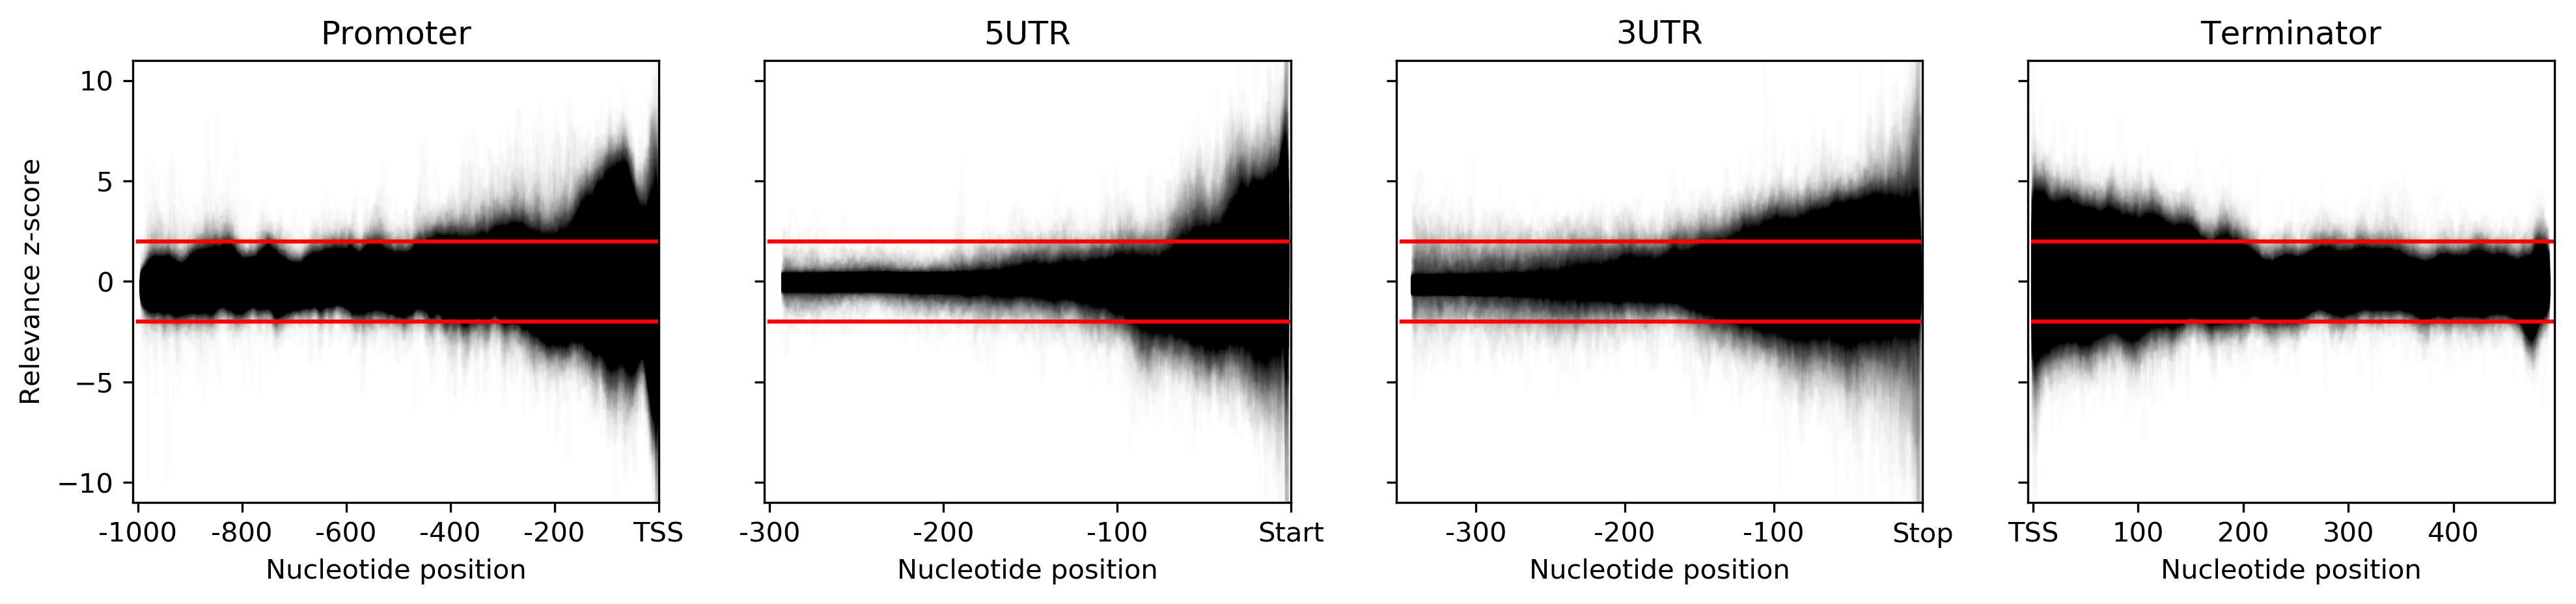

In [6]:
# plot relevance

mpl.rcParams['figure.dpi'] = 300

f2 = plt.figure(figsize=(16,3))
axarr2 = f2.subplots(1,4, sharey=True)

for i in range(len(limits)):
    tmp_original = zscore(RR_occlusions[:,limits[i][0]:limits[i][1]-window+1])    
    for x in tmp_original:
        if i==3:
            axarr2[i].plot(x,alpha=0.01,c='k')
        else:
            axarr2[i].plot(list(range(window-2,tmp_original[0].shape[0]+window-2,1)),x,alpha=0.01,c='k')
    axarr2[i].plot([xx-limits[i][0] for xx in limits[i]],[2,2],'r')
    axarr2[i].plot([xx-limits[i][0] for xx in limits[i]],[-2,-2],'r')
    axarr2[i].set_title(names_plot[i])
    axarr2[i].set_xlabel('Nucleotide position')
    kscale = limits[i][1]-limits[i][0]
    axarr2[i].set_xlim([limits[i][0]-limits[i][0]-kscale/100,
                        limits[i][1]-limits[i][0]-window+1+kscale/100])
    #plt.axis('tight')
    if i == 0:
        axarr2[i].set_ylabel('Relevance z-score')
        
# fix coordinates
tmp = [str(x) for x in list(range(-1200,0,200))]
tmp.extend(['TSS'])
axarr2[0].set_xticklabels(tmp)

axarr2[1].set_xticks(list(range(0,301,100)))
tmp = [str(x) for x in list(range(-300,0,100))]
tmp.extend(['Start'])
axarr2[1].set_xticklabels(tmp)

axarr2[2].set_xticks(list(range(50,351,100)))
tmp = [str(x) for x in list(range(-300,0,100))]
tmp.extend(['Stop'])
axarr2[2].set_xticklabels(tmp)

axarr2[3].set_xticks(list(range(0,500,100)))
tmp = ['TSS','100','200','300','400']
axarr2[3].set_xticklabels(tmp)
    
plt.ylim([-11,+11])
f2.savefig('f3a.svg')


In [7]:
# num base pair per region on average per gene above cutoff
data = df_seqs_all.groupby(['Y_bin','region','gene_id'])['motif'].apply(lambda x: x.str.len().sum()).reset_index()
data.groupby(['region'])['motif'].mean().apply(np.round)

region
0_promoter      214.0
1_5UTR           74.0
2_3UTR           94.0
3_terminator    127.0
Name: motif, dtype: float64

# Clustering

In [8]:
# load data into gene_id sorted dframe

cluster = pd.read_csv(folder+fn4).rename(columns={'gene':'gene_id'})
print(cluster.shape)

# fix cluster sort
cdic = {1:1,2:2,3:4,4:3}
cluster['cluster'] = cluster.cluster.apply(lambda x: cdic[x])
cluster.head()

Y, gene_names, cf = load_data(folder+fn3)

bin_edges = [0, .25, .5, .75, 1.]
labels = [0,1,2,3]   
Y_q = np.array(pd.qcut(Y.reshape((-1,)),q=bin_edges,labels=labels, retbins=False))
print(Y_q.shape)

df = pd.DataFrame(gene_names,columns=['gene_id'])
df['box'] = Y
df['tpm'] = df.box.apply(boxtpm,lmbda=0.22)
df['quartile'] = Y_q
df['cluster'] = cluster.set_index('gene_id').loc[df.gene_id].values
df.head()

(4238, 2)
(4238,)


,gene_id,box,tpm,quartile,cluster
0,YLR410W,8.677561,128.223909,3,2
1,YMR177W,5.185425,31.813583,0,2
2,YGL201C,6.975679,68.547308,2,1
3,YNL066W,9.809168,186.236885,3,4
4,YER094C,10.922983,261.569421,3,2


In [9]:
# concat index gene names cluster and zscores

#plot
df_zocc = []

# for region
for i in range(len(limits)):
    tmp_original = zscore(RR_occlusions[:,limits[i][0]:limits[i][1]-window+1])    
    df_zocc.append(pd.DataFrame(tmp_original))
    df_zocc[-1]['gene_id'] = gene_names
    df_zocc[-1]['cluster'] = df.set_index('gene_id').loc[df_zocc[-1]['gene_id']].cluster.values
    df_zocc[-1]['region'] = names[i]

df_zocc = pd.concat(df_zocc).set_index(['region','gene_id','cluster'])
print(df_zocc.shape)
df_zocc = (df_zocc
           .stack()
           .reset_index()
           .rename(columns={'level_3':'position',0:'value'})
          )
df_zocc.head()  

(16952, 991)


,region,gene_id,cluster,position,value
0,0_promoter,YLR410W,2,0,-0.238604
1,0_promoter,YLR410W,2,1,-0.285414
2,0_promoter,YLR410W,2,2,-0.281973
3,0_promoter,YLR410W,2,3,-0.067089
4,0_promoter,YLR410W,2,4,-0.153605


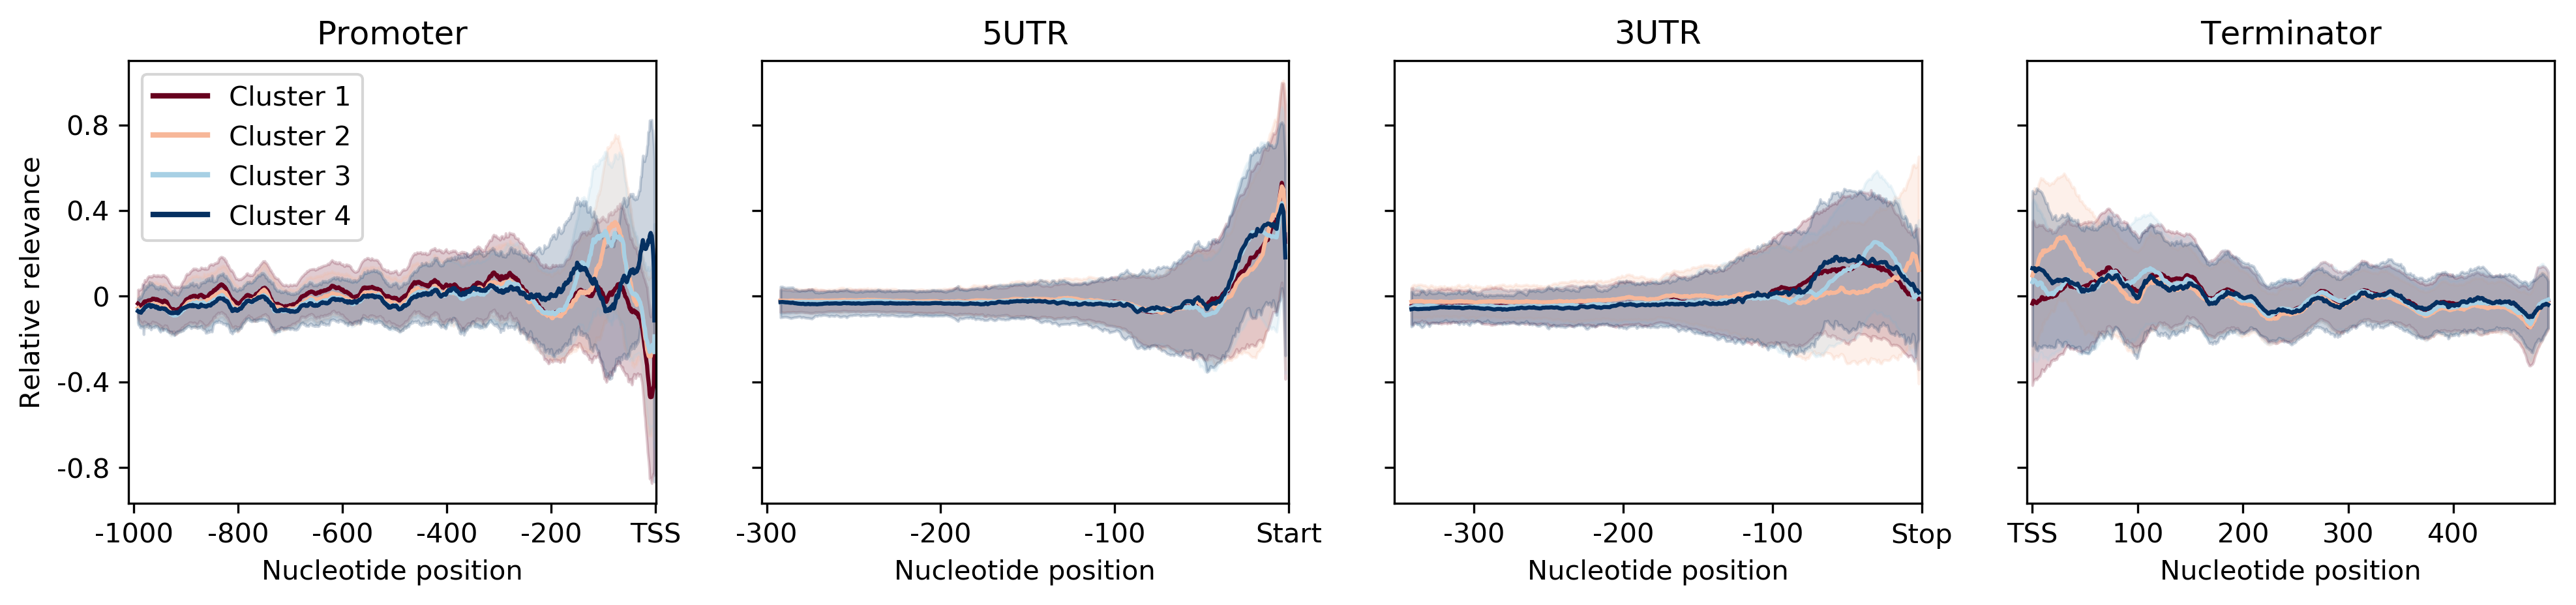

In [10]:
# fig clustering of relevance profiles

f2 = plt.figure(figsize=(16,3))
axarr2 = f2.subplots(1,4, sharey=True)
legend = 'full'
cmap = mpl.cm.get_cmap('RdBu')

for i in range(4):
#     if i > 0:
#         legend = False

    tmp = df_zocc[df_zocc.region==names[i]]
    if i<3:
        tmp['position'] = tmp['position']+window-2
    sns.lineplot(x="position", y="value", ci='sd',
                hue="cluster", data=tmp[tmp.region==names[i]],
                ax=axarr2[i], legend=False,#legend=legend,
                palette="RdBu")
                #palette="Paired")
                #palette="seismic")
    axarr2[i].set_title(names_plot[i])
    axarr2[i].set_xlabel('Nucleotide position')
    kscale = limits[i][1]-limits[i][0]
    axarr2[i].set_xlim([limits[i][0]-limits[i][0]-kscale/100,
                 limits[i][1]-limits[i][0]-window+1+kscale/100])
        #plt.axis('tight')
    if i == 0:
        axarr2[i].set_ylabel('Relative relevance')
        custom_lines = [Line2D([0], [0], color=cmap(0), lw=2),
                       Line2D([0], [0], color=cmap(0.3333), lw=2),
                       Line2D([0], [0], color=cmap(0.6666), lw=2),
                       Line2D([0], [0], color=cmap(1.0), lw=2)]
        axarr2[i].legend(custom_lines,['Cluster 1','Cluster 2','Cluster 3','Cluster 4'])

# fix coordinates
tmp = [str(x) for x in list(range(-1200,0,200))]
tmp.extend(['TSS'])
axarr2[0].set_xticklabels(tmp)

axarr2[1].set_xticks(list(range(0,301,100)))
tmp = [str(x) for x in list(range(-300,0,100))]
tmp.extend(['Start'])
axarr2[1].set_xticklabels(tmp)

axarr2[2].set_xticks(list(range(50,351,100)))
tmp = [str(x) for x in list(range(-300,0,100))]
tmp.extend(['Stop'])
axarr2[2].set_xticklabels(tmp)

axarr2[3].set_xticks(list(range(0,500,100)))
tmp = ['TSS','100','200','300','400']
axarr2[3].set_xticklabels(tmp)

axarr2[0].set_yticklabels([-1.2,-0.8,-0.4,0,0.4,0.8])

plt.savefig('f3b.svg')


In [11]:
# load gene variance data to df
tmp = pd.read_csv(folder+fn0)
tmp.head()
df['var'] = tmp.groupby('gene_id').TPM.var().loc[df.gene_id].values
df.head()

,gene_id,box,tpm,quartile,cluster,var
0,YLR410W,8.677561,128.223909,3,2,2357.770169
1,YMR177W,5.185425,31.813583,0,2,329.850374
2,YGL201C,6.975679,68.547308,2,1,547.978736
3,YNL066W,9.809168,186.236885,3,4,37735.426404
4,YER094C,10.922983,261.569421,3,2,25850.321172


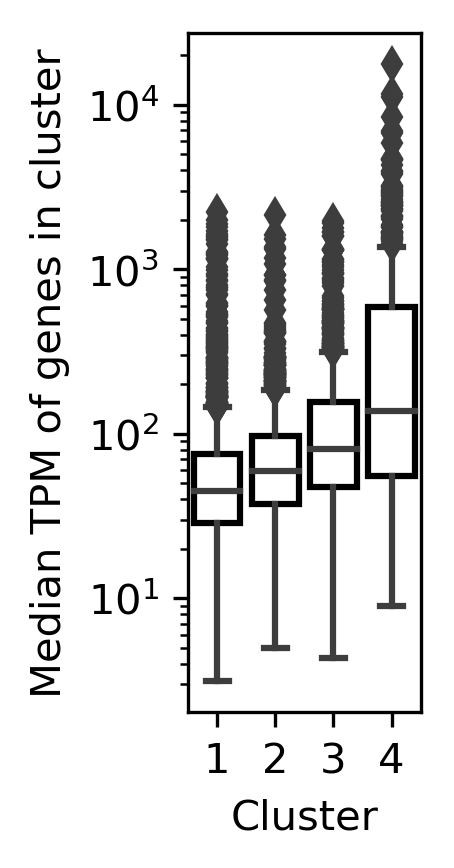

In [12]:
# fig TPM across clusters
plt.figure(figsize=(1,3))
#plt.subplot(1,2,1)
ax = sns.boxplot(data=df,x='cluster',y='tpm')
plt.yscale('log')
plt.xlabel('Cluster')
plt.ylabel('Median TPM of genes in cluster')

for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

plt.savefig('f3d.svg')


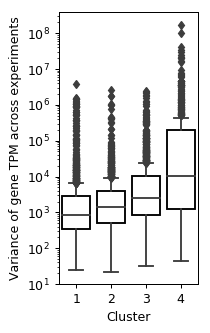

In [13]:
mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(2,4))
ax = sns.boxplot(data=df,x='cluster',y='var')
plt.yscale('log')
plt.xlabel('Cluster')
plt.ylabel('Variance of gene TPM across experiments')

for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
    
plt.show()

In [14]:
# transcriptional plasticity per cluster

print(df.groupby('cluster').tpm.apply(np.median))
print(df.groupby('cluster').tpm.apply(dynamic_range))
print(df.groupby('cluster')['var'].apply(np.median))


cluster
1     44.596673
2     58.898735
3     80.544455
4    137.568064
Name: tpm, dtype: float64
cluster
1    3.347342
2    3.328442
3    3.292673
4    4.249025
Name: tpm, dtype: float64
cluster
1      828.698777
2     1371.083880
3     2574.660566
4    10069.399895
Name: var, dtype: float64


In [15]:
# significant difference tpm distributions across clusters

def pariwise_pval(dfp,col1,col2):
    pval = []
    for i in range(len(dfp[col1].unique())):
        for j in range(i+1,len(dfp[col1].unique())):
            xx = dfp[dfp[col1]==dfp[col1].unique()[i]][col2]
            yy = dfp[dfp[col1]==dfp[col1].unique()[j]][col2]
            #tmp = stats.ttest_ind(xx, yy)
            tmp = stats.ranksums(xx, yy)
            pval.append([dfp[col1].unique()[i],dfp[col1].unique()[j],tmp[1]])

    pval = pd.DataFrame(pval,columns=['model_x','model_y','pval'])
    return pval

pariwise_pval(df,'cluster','tpm')

,model_x,model_y,pval
0,2,1,2.669042e-16
1,2,4,1.065703e-43
2,2,3,4.374261e-24
3,1,4,1.454998e-65
4,1,3,2.829349e-65
5,4,3,1.044456e-18


In [16]:
# significance of tpm variance across clusters

def pariwise_pval(dfp,col1,col2):
    pval = []
    for i in range(len(dfp[col1].unique())):
        for j in range(i+1,len(dfp[col1].unique())):
            xx = dfp[dfp[col1]==dfp[col1].unique()[i]][col2]
            yy = dfp[dfp[col1]==dfp[col1].unique()[j]][col2]
            #tmp = stats.ttest_ind(xx, yy)
            tmp = stats.levene(xx, yy)
            pval.append([dfp[col1].unique()[i],dfp[col1].unique()[j],tmp[1]])

    pval = pd.DataFrame(pval,columns=['model_x','model_y','pval'])
    return pval

pariwise_pval(df,'cluster','tpm')

,model_x,model_y,pval
0,2,1,1.029964e-01
1,2,4,4.474308e-34
2,2,3,4.191094e-09
3,1,4,7.048922e-37
4,1,3,1.615306e-04
5,4,3,1.929027e-29


In [17]:
## Load TATA/consitutive data

saga = pd.read_csv(folder+fn14)
print(saga.shape)
saga = saga.set_index('gene_id').loc[gene_names].group
saga.head()

#tfiid/saga cluster enrichment
df['saga'] = saga.values
df.head()
df.groupby(['saga'])['cluster'].value_counts().unstack()


(4238, 3)


cluster,1,2,3,4
saga,,,,
SAGA-dominated,56,32,60,59
SAGA/TFIID,24,6,14,10
TFIID-dominated,1251,1104,1085,380
no call,54,45,47,11


In [18]:
# opn/dpn

tmp = pd.read_csv(folder+fn15, sep=';').drop(columns=['Unnamed: 1','Unnamed: 3'])

tirosh = pd.DataFrame(tmp['DPN genes'].dropna().str.strip("'").values,columns=['gene_id'])
tirosh['opn_dpn'] = 'dpn'
tirosh.head()

tmp_opn = list(tmp['OPN genes'].loc[:510].str.strip("'").values)
tmp2 = [x.split('\n') for x in tmp['OPN genes'][511].split(' ')]
tmp_opn.extend([x.strip("'") for el in tmp2 for x in el])

df_tmp = pd.DataFrame(tmp_opn,columns=['gene_id'])
df_tmp['opn_dpn'] = 'opn'
tirosh = tirosh.append(df_tmp)
print(tirosh.shape)

df = df.merge(tirosh,on='gene_id',how='left')
    
print(df.shape)
df[~df.opn_dpn.isna()].groupby(['opn_dpn'])['cluster'].value_counts().unstack()

(1038, 2)
(4238, 8)


cluster,1,2,3,4
opn_dpn,,,,
dpn,157,136,145,26
opn,107,69,105,76


In [19]:
## enrichment OPN DPN in cluster 3 (=high)
# group x / not-x
# data / not-data

data = df[~df.opn_dpn.isna()].groupby(['opn_dpn'])['cluster'].value_counts().unstack()
data = pd.DataFrame([data[4],data[[1,2,3]].sum(axis=1)]).transpose()
print(data) 

stats.fisher_exact([data.iloc[0].values,data.iloc[1].values], alternative='two-sided')

          4  Unnamed 0
opn_dpn               
dpn      26        438
opn      76        281


(0.2194784907474165, 1.9347915210503005e-11)

In [20]:
## enrichment saga in cluster 3 (=high)

data = df.groupby(['saga'])['cluster'].value_counts().unstack()
data = pd.DataFrame([data.iloc[0,:],data.iloc[[1,2,3],:].sum()])
data = pd.DataFrame([data[4],data.iloc[:,[0,1,2]].sum(axis=1)]).transpose()
print(data)

stats.fisher_exact([data.iloc[0].values,data.iloc[1].values], alternative='two-sided')

                  4  Unnamed 0
SAGA-dominated   59        148
Unnamed 0       401       3630


(3.6087146997371438, 4.2846420300643916e-13)

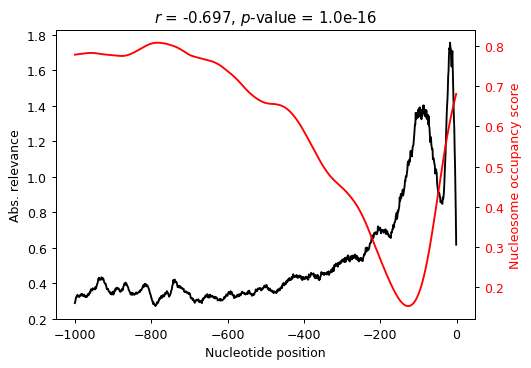

In [21]:
# fig 3 supplement

mpl.rcParams['figure.dpi'] = 90

RR_zscore = [] #np.zeros((RR_occlusions.shape[0],RR_occlusions.shape[1]))
for i in range(len(limits)):
    RR_zscore.append(zscore(RR_occlusions[:,limits[i][0]:limits[i][1]]))
RR_zscore = np.concatenate(RR_zscore, axis=1)

df_zhang = pd.read_excel(folder+fn16, header=2, index_col=1).drop(columns=['Unnamed: 0'])

x = np.median(np.abs(RR_zscore[:,:1000]), axis=0)
y = df_zhang.loc[-999:0,'Gln_TATA_Less'].values

pcc = stats.pearsonr(x,y)
pcc = tuple([pcc[0],fix_pvals(pcc[1])])

fig, ax1 = plt.subplots()

ax1.set_xlabel('Nucleotide position')
ax1.set_ylabel('Abs. relevance')
ax1.plot(range(-1000,0),x,color='k')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Nucleosome occupancy score',color='r')  # we already handled the x-label with ax1
ax2.plot(range(-1000,0),y,color='r')
ax2.tick_params(axis='y',labelcolor='r')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('$r$ = %.3f, $p$-value = %.1e'%pcc)
plt.show()


# Motifs

In [22]:
## load data

# reformat list and set variables
df_seqs = pd.read_csv(folder+fn10)
df_motifs = pd.read_csv(folder+fn11)
df_rules = pd.read_csv(folder+fn12)

df_rules = fix_frame(df_rules)

df_motifs['genes'] = df_motifs.genes.apply(fix_int_list)
df_motifs['gene_ids'] = df_motifs.gene_ids.apply(fix_strings_list_space)
df_motifs['ytest'] = df_motifs.ytest.apply(fix_float_list_comma)

# drop precalculated values except y boxcox
df_rules.drop(columns=['y_mean','y_std','y_var','ytpm_mean','ytpm_std','ytpm_var','ytpm_median','ytpm'],
             inplace=True)

print(df_seqs.shape)
print(df_motifs.shape)
print(df_rules.shape)

(74728, 16)
(2210, 19)
(308328, 17)


In [23]:
# gene sequence indices correspond to gene names in stored dataset
df_names = pd.DataFrame(gene_names,columns=['gene_id'])
df_names.loc[df_motifs.iloc[0].genes].gene_id

0       YLR410W
2       YGL201C
6       YDL102W
4229    YIL154C
4230    YJL155C
4231    YHR143W
Name: gene_id, dtype: object

In [24]:
# rules subsets
rules_sig, rules_fdr, rules_bonf = return_significant_rules(df_rules, p_cut=0.05)

# keep unique itemsets
rules_sig = filter_rules(rules_sig)
rules_fdr = filter_rules(rules_fdr)
rules_bonf = filter_rules(rules_bonf)
print(rules_sig.shape)
print(rules_fdr.shape)
print(rules_bonf.shape)

(25809, 18)
(9962, 18)
(1541, 18)


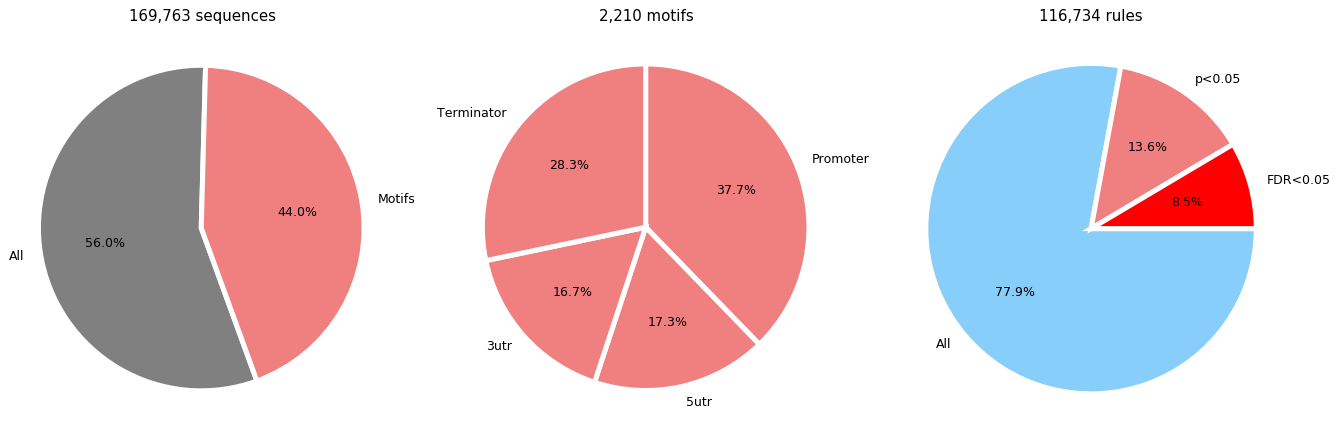

In [25]:
## Pie chart motif data

mpl.rcParams['figure.dpi'] = 90
f2 = plt.figure(figsize=(15,5))

# Pie chart - num sequences
ax = plt.subplot(1, 3, 1)

# Data to plot
labels = ['All','Motifs']
sizes = [169763-df_seqs.shape[0],df_seqs.shape[0]]
colors = ['grey','lightcoral']
explode = (0, 0.1)  # explode 1st slice

# Plot
pltdat = ax.pie(sizes,  labels=labels, autopct='%1.1f%%', #explode=explode,
        colors=colors, shadow=False, startangle=290, 
        counterclock=False)

plt.axis('equal')
x = str(169763)
plt.title(x[:3]+',' +x[3:]+' sequences')

for w in pltdat[0]:
    w.set_linewidth(4)
    w.set_edgecolor('white')

# Pie chart - num motifs per region
ax = plt.subplot(1, 3, 2)

dat_reg = (df_motifs
 .reset_index()
 .groupby('region')['cluster']
 .count())
dat_reg.index = [x.split('_')[1].capitalize() for x in dat_reg.index.values]

# Data to plot
labels = dat_reg.index.values
sizes = dat_reg.values
colors = ['maroon','lightcoral','mistyrose','seashell']
colors = ['lightcoral' for i in range(4)]
explode = (0.1, 0.1, 0.1, 0.1)  # explode 1st slice

# Plot
pltdat = ax.pie(sizes,  labels=labels, autopct='%1.1f%%', #explode=explode,
        colors=colors, shadow=False, startangle=90, 
        counterclock=False)

plt.axis('equal')
x = str(df_motifs.shape[0])
plt.title(x[:1]+',' +x[1:]+' motifs')

for w in pltdat[0]:
    w.set_linewidth(4)
    w.set_edgecolor('white')


# Pie chart num rules 

ax = plt.subplot(1, 3, 3)

# Data to plot
labels = ['All','p<0.05','FDR<0.05']
sizes = [filter_rules(df_rules).shape[0]-rules_sig.shape[0],rules_sig.shape[0]-rules_fdr.shape[0],rules_fdr.shape[0]]
colors = ['lightskyblue','lightcoral','red']
explode = (0, 0, 0)  # explode 1st slice

# Plot
pltdat = ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode,
        colors=colors, shadow=False, startangle=0, 
        counterclock=False)

plt.axis('equal')
x = str(filter_rules(df_rules).shape[0])
plt.title(x[:3]+',' +x[3:]+' rules')

for w in pltdat[0]:
    w.set_linewidth(4)
    w.set_edgecolor('white')

plt.tight_layout()
plt.show()


(183200, 12)
(176366, 12)
(169763, 14)


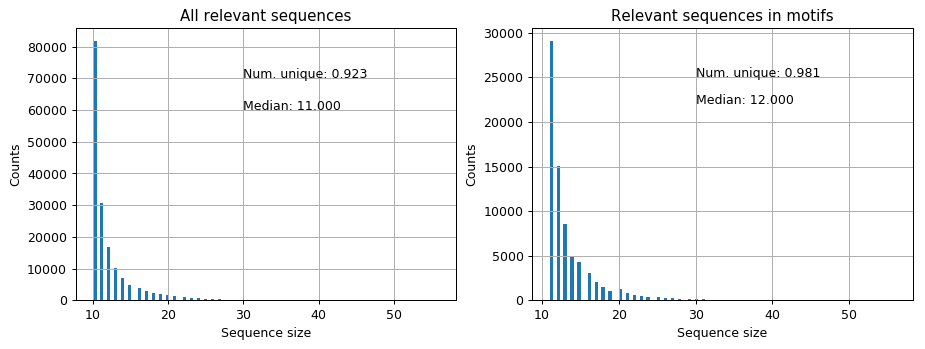

In [26]:
# distributions of lengths all,
# in motifs,
# across genes

## load extracted sequences

# fix from string conversion at save
# def fix_strings_list(x):
#     return [xxx for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0]

def fix_strings_list_float(x):
    return [float(xxx) for xxx in [str(xx.replace("'","").replace(']','').replace('[','').replace(' ','')) for xx in list(x.split(' '))] if len(xxx)>0]

def fix_strings_tuple_int(x):
    return tuple([int(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0])


def load_seqs_data(fname, ks):
    motifs = pd.read_csv(fname,sep=';')
    #motifs_shuffled = pd.read_csv('minsystem_occlusion10_motifs_shuffled_frame.csv',sep=';')
    print(motifs.shape)
    #print(motifs_shuffled.shape)

    # preprocessing
    motifs.motif = motifs.motif.str.strip("''[]")
    #motifs_shuffled.motif = motifs_shuffled.motif.str.strip("''[]")

    def filter_seqs_with_Ns(motifs):
        tmp = np.invert(motifs.motif.str.contains('N'))
        return motifs[tmp]

    motifs = filter_seqs_with_Ns(motifs)
    #motifs_shuffled = filter_seqs_with_Ns(motifs_shuffled)
    print(motifs.shape)
    #print(motifs_shuffled.shape)

    # filter edge notif results below k
    motifs = motifs[motifs.motif.apply(lambda x: len(x)).values >= max(ks)]
    #motifs_shuffled = motifs_shuffled[motifs_shuffled.motif.apply(lambda x: len(x)).values >= k]
    
    # fix y pred bin
    motifs.at[motifs['Y_pred_bin']==-1,'Y_pred_bin'] = 0
    
    # fix names Y to Y_test for pipeline
    motifs['Y_test'] = motifs.Y
    motifs['Y_test_bin'] = motifs.Y_bin
    
    print(motifs.shape)
    #print(motifs_shuffled.shape)
    
    return motifs

df_seqs_all = load_seqs_data(folder+fn13, [10])
df_seqs_all['zscores'] = df_seqs_all.zscores.apply(fix_strings_list_float)
df_seqs_all['peak_index'] = df_seqs_all.peak_index.apply(fix_strings_tuple_int)
df_seqs_all.head()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
df_seqs_all.motif.str.len().hist(bins = 100)
plt.xlabel('Sequence size')
plt.ylabel('Counts')
plt.title('All relevant sequences')
plt.annotate('Num. unique: %.3f'%(len(set(df_seqs_all.motif.unique()))/df_seqs_all.shape[0]),xy=(30,70000))
plt.annotate('Median: %.3f'%df_seqs_all.motif.str.len().median(),xy=(30,60000))
plt.subplot(1,2,2)
df_seqs.motif.str.len().hist(bins = 100)
plt.xlabel('Sequence size')
plt.ylabel('Counts')
plt.title('Relevant sequences in motifs')
plt.annotate('Num. unique: %.3f'%(len(set(df_seqs.motif.unique()))/df_seqs.shape[0]),xy=(30,25000))
plt.annotate('Median: %.3f'%df_seqs.motif.str.len().median(),xy=(30,22000))
plt.show()


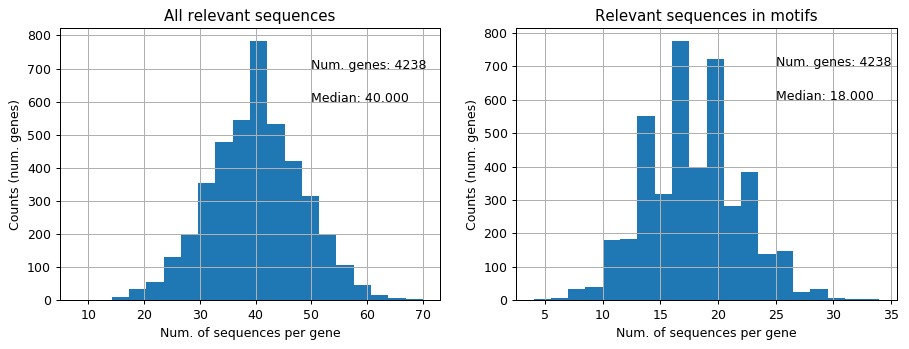

In [27]:
# Average num. of seqs per gene, in motifs

# average number of motifs per gene
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
df_seqs_all.groupby('seq_index')['motif'].count().hist(bins=20)
plt.xlabel('Num. of sequences per gene')
plt.ylabel('Counts (num. genes)')
plt.title('All relevant sequences')
plt.annotate('Num. genes: %d'%df_seqs_all.seq_index.unique().shape[0],xy=(50,700))
plt.annotate('Median: %.3f'%df_seqs_all.groupby('seq_index')['motif'].count().median(),xy=(50,600))

plt.subplot(1,2,2)
df_seqs.groupby('seq_index')['motif'].count().hist(bins=20)
plt.xlabel('Num. of sequences per gene')
plt.ylabel('Counts (num. genes)')
plt.title('Relevant sequences in motifs')
plt.annotate('Num. genes: %d'%df_seqs.seq_index.unique().shape[0],xy=(25,700))
plt.annotate('Median: %.3f'%df_seqs.groupby('seq_index')['motif'].count().median(),xy=(25,600))
plt.show()

In [28]:
# motifs barplot - include
# number all identified motifs
# num overlapped
# num that hit to database

# load tomtom pairwise
df_pair = pd.read_csv(folder+fn6)

dat_reg = (df_motifs
 .reset_index()
 .groupby('region')['cluster']
 .count()
 .reset_index()
 )
dat_reg.index = names_plot

df_reg = dat_reg.reset_index()
df_reg = df_reg.merge(df_pair
             .loc[(df_pair.query_region!='all')&(df_pair.seq_id==0.8),['query_region','query_perc']],
            left_on='region',right_on='query_region',how='left')
df_reg['overlap'] = df_reg.cluster.multiply(df_reg.query_perc).astype(np.int)
df_reg

,index,region,cluster,query_region,query_perc,overlap
0,Promoter,0_promoter,834,0_promoter,0.134293,112
1,5UTR,1_5UTR,383,1_5UTR,0.169713,65
2,3UTR,2_3UTR,368,2_3UTR,0.173913,63
3,Terminator,3_terminator,625,3_terminator,0.132800,83


In [29]:
# amount queries

folders = ['tomtom_jaspar-fungi_08_trimmed/',
           'tomtom_yeastract_08_trimmed/']
df_dbs =[]
for folder2 in folders:
    tomtom2 = pd.read_csv(folder+folder2+'tomtom.txt',sep='\t')
    tomtom2.drop(index=tomtom2.index.values[-3:],inplace=True)
    tomtom2.tail()
    # filter at least 0.01 evalue
    df_dbs.append(tomtom2[(tomtom2['E-value']<0.05) & (tomtom2['q-value']<0.05)])

df_dbs = pd.concat(df_dbs)    
print(df_dbs['#Query ID'].unique().shape[0]/df_motifs.shape[0])

0.12895927601809956


In [30]:
# load tomtom databases
df_dbs = pd.read_csv(folder+fn5)

# table S3-1
# jaspar hits
print(df_dbs
 .loc[(df_dbs.database=='jaspar')&(df_dbs.query_region=='all'),['seq_id','target_perc']]
 .set_index('seq_id')
)

# overall % unique hits in databases
print(df_dbs
 .loc[(df_dbs.seq_id==0.8)&(df_dbs.query_region=='all'),['database','query_region','target_perc']]
 .set_index(['database'])
)

        target_perc
seq_id             
0.80       0.380682
0.85       0.181818
0.90       0.187500
          query_region  target_perc
database                           
jaspar             all     0.380682
yeastract          all     0.630682


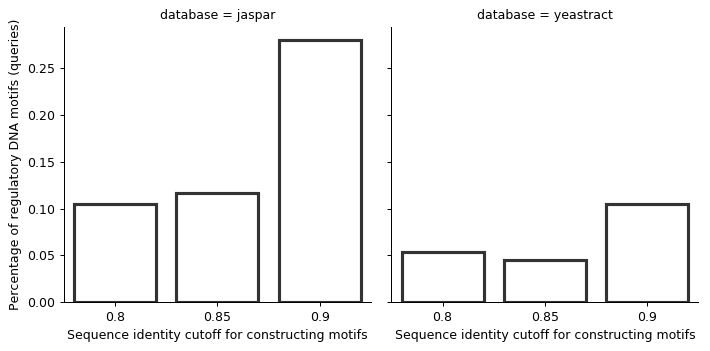

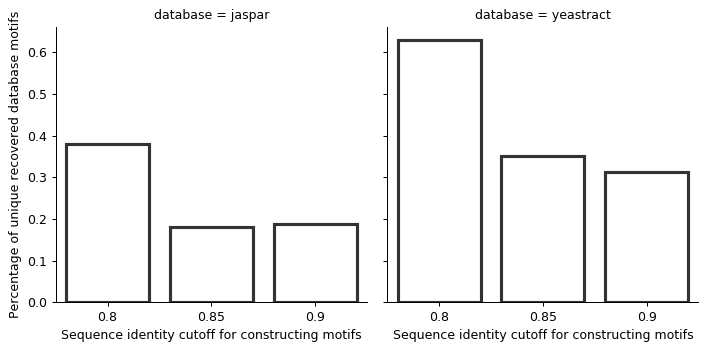

In [31]:
# supplementary plot query target hits databases vs seq. id.

g = sns.catplot(data = df_dbs.loc[(df_dbs.query_region=='all'),:],
            x='seq_id',y='query_perc',col='database',kind='bar',
           linewidth=2.5, facecolor='white',
           errcolor=".2", edgecolor=".2", height=4)
g.axes.flatten()[0].set_ylabel('Percentage of regulatory DNA motifs (queries)')
for ax in g.axes.flatten():
    ax.set_xlabel('Sequence identity cutoff for constructing motifs')
plt.show()

g = sns.catplot(data = df_dbs.loc[(df_dbs.query_region=='all'),:],
            x='seq_id',y='target_perc',col='database',kind='bar',
           linewidth=2.5, facecolor='white',
           errcolor=".2", edgecolor=".2", height=4)
g.axes.flatten()[0].set_ylabel('Percentage of unique recovered database motifs')
for ax in g.axes.flatten():
    ax.set_xlabel('Sequence identity cutoff for constructing motifs')
plt.show()

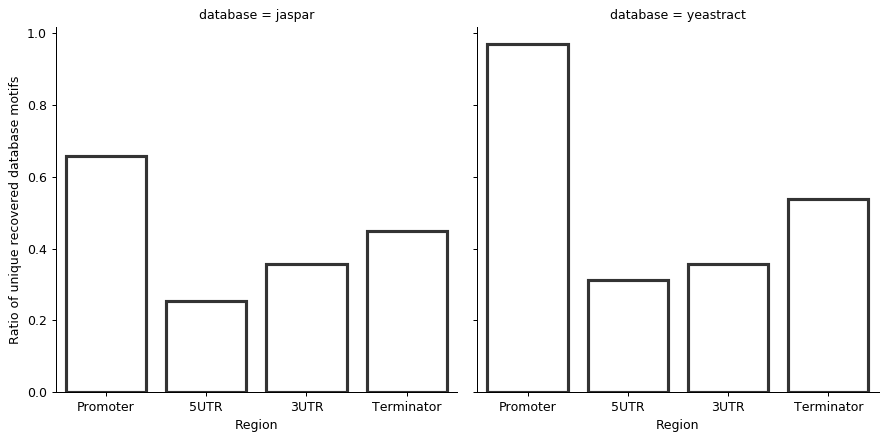

In [32]:
# Percentage of hits across regions
# show Jaspar

df_plot = (df_dbs
 .loc[(df_dbs.seq_id==0.8),['database','query_region','target_hits']]
)

div1 = df_plot.loc[(df_plot.query_region=='all')&(df_plot.database=='jaspar'),'target_hits'].values[0]
div2 = df_plot.loc[(df_plot.query_region=='all')&(df_plot.database=='yeastract'),'target_hits'].values[0]
df_plot.loc[df_plot.database=='jaspar','target_hits'] = (df_plot
                                           .loc[df_plot.database=='jaspar','target_hits']
                                           .divide(div1)
                                          )
df_plot.loc[df_plot.database=='yeastract','target_hits'] = (df_plot
                                           .loc[df_plot.database=='yeastract','target_hits']
                                           .divide(div1)
                                          )
df_plot = df_plot[(df_plot.query_region!='all')]#&(df_plot.database=='jaspar')]
df_plot['Region'] = [el for it in [names_plot,names_plot] for el in it] # names_plot

g = sns.catplot(data=df_plot,
           x='Region',y='target_hits',col='database',kind='bar',
           linewidth=2.5, facecolor='white',
           errcolor=".2", edgecolor=".2")
g.axes.flatten()[0].set_ylabel('Ratio of unique recovered database motifs')

plt.show()

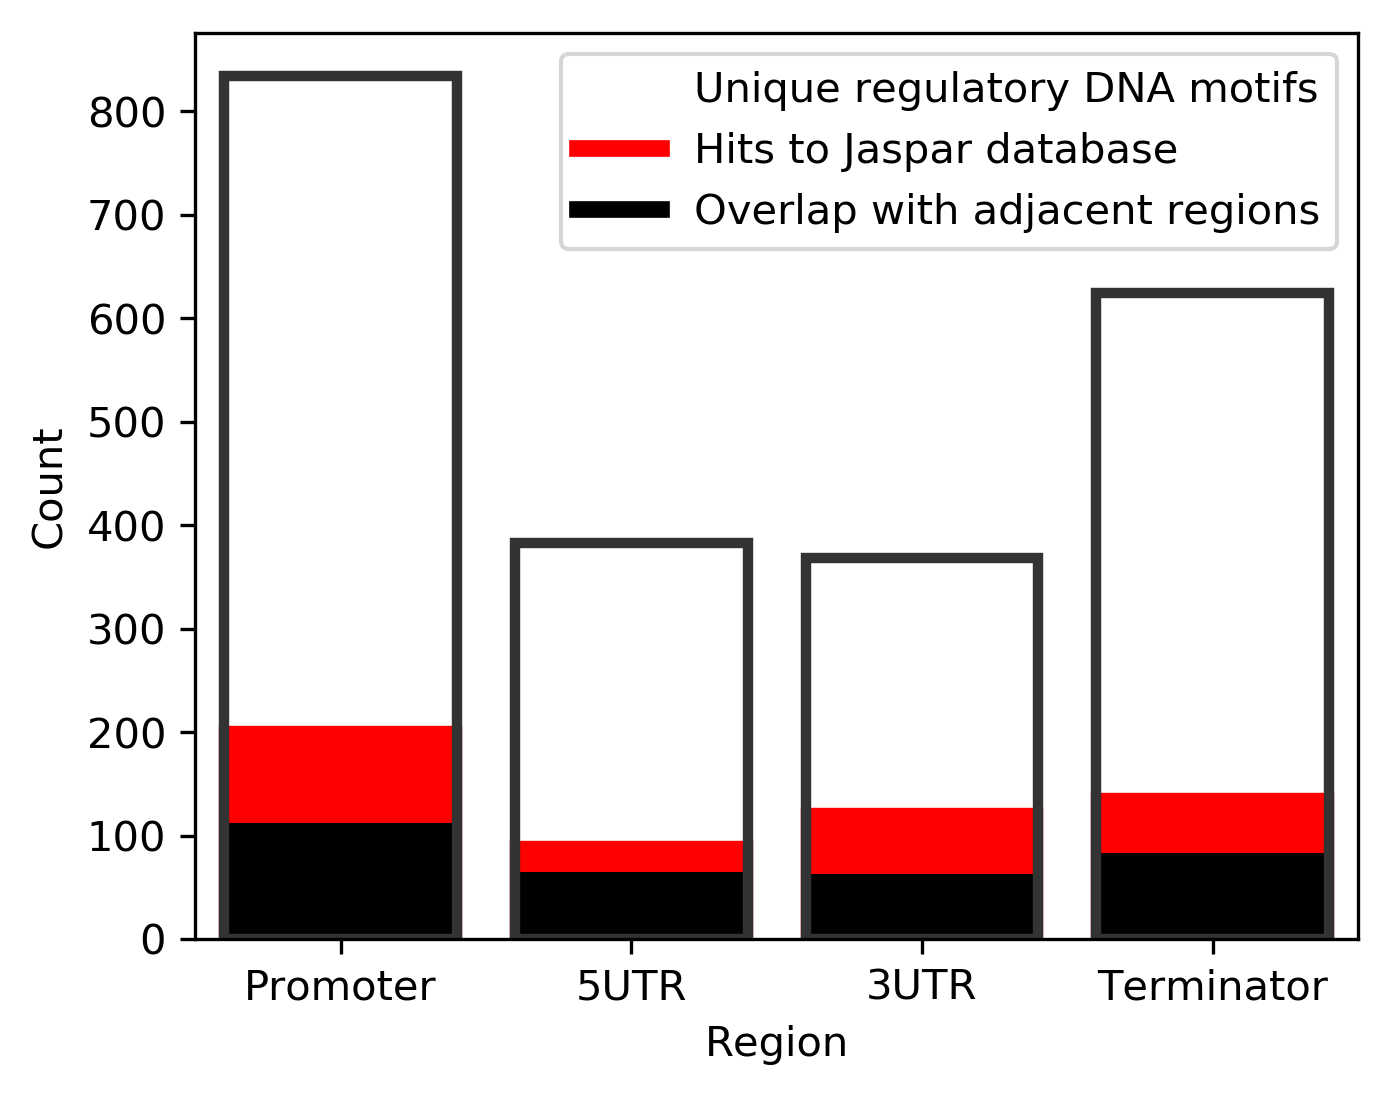

In [33]:
## expand motifs barplot

mpl.rcParams['figure.dpi'] = 300

df_reg['db_query_perc'] = df_dbs.loc[(df_dbs.query_region!='all')
                       &(df_dbs.seq_id==0.8)
                       &(df_dbs.database=='jaspar'),
                      'query_perc']
df_reg['db_query'] = df_reg.cluster.multiply(df_reg.db_query_perc).astype(np.int)
df_reg['db_query_plot'] = df_reg.db_query+df_reg.overlap
df_reg

plt.figure(figsize=(5,4))

sns.barplot(data=df_reg,
            x='index',y='db_query_plot',
            linewidth=2.5, facecolor='red',
           errcolor=".2", edgecolor='red')
sns.barplot(data=df_reg,
            x='index',y='overlap',
            linewidth=0, facecolor='black',
           errcolor=".2", edgecolor=".2")
sns.barplot(data=df_reg,
            x='index',y='cluster',
            linewidth=2.5, facecolor='none',
           errcolor=".2", edgecolor=".2")

#sns.despine()
plt.xlabel('Region')
plt.ylabel('Count')

# legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='white', lw=4),
                Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='black', lw=4)]

# fig, ax = plt.subplots()
# lines = ax.plot(data)
plt.legend(custom_lines, ['Unique regulatory DNA motifs',
                         'Hits to Jaspar database',
                         'Overlap with adjacent regions'])

plt.savefig('f3e.svg')

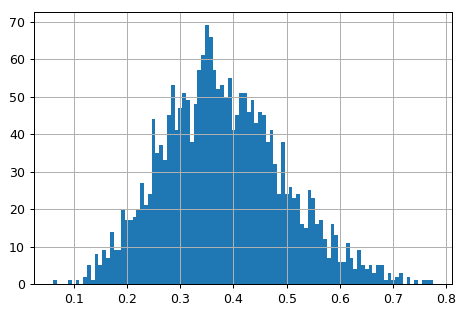

,cluster,gc,Region
0,0_0,0.208910,Promoter
1,0_1,0.230076,Promoter
2,0_10,0.354074,Promoter
3,0_100,0.494604,Promoter
4,0_1000,0.465909,Promoter


In [34]:
# GC content

def GC_content(seq):
    if len(seq) > 0:
        output = sum([i in ['G','C'] for i in seq])/len(seq)
    else:
        output = 0
    return output

mpl.rcParams['figure.dpi'] = 90

gc = df_seqs.groupby('cluster')['motif'].sum().apply(GC_content)
gc.hist(bins=100)
plt.show()
gc.describe()

# across regions
gc = gc.reset_index().rename(columns={'motif':'gc'})
gc['Region'] = gc.cluster.apply(lambda x: names_plot[int(x.split('_')[0])])
gc.head()


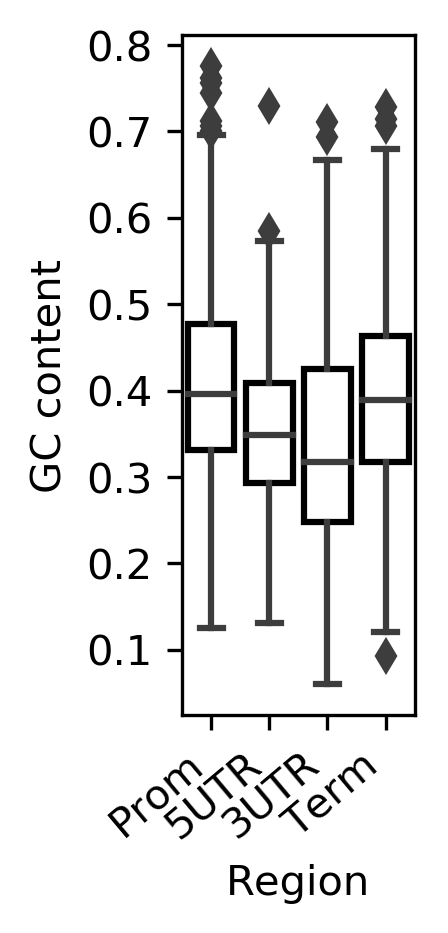

In [35]:
# boxplot gc regions

gc['Region'] = gc.Region.apply(lambda x: x[:4])

mpl.rcParams['figure.dpi'] = 300

plt.figure(figsize=(1,3))
#plt.subplot(1,2,1)
ax = sns.boxplot(data=gc,x='Region',y='gc')
plt.xlabel('Region')
plt.ylabel('GC content')

for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
plt.xticks(rotation=40,ha="right")

plt.savefig('f3c.svg')


In [36]:
# significance gc chagnes
def pariwise_pval(dfp,col1,col2):
    pval = []
    for i in range(len(dfp[col1].unique())):
        for j in range(i+1,len(dfp[col1].unique())):
            xx = dfp[dfp[col1]==dfp[col1].unique()[i]][col2]
            yy = dfp[dfp[col1]==dfp[col1].unique()[j]][col2]
            #tmp = stats.ttest_ind(xx, yy)
            tmp = stats.ranksums(xx, yy)
            pval.append([dfp[col1].unique()[i],dfp[col1].unique()[j],tmp[1]])

    pval = pd.DataFrame(pval,columns=['model_x','model_y','pval'])
    return pval

pariwise_pval(gc,'Region','gc')

,model_x,model_y,pval
0,Prom,5UTR,5.468798e-15
1,Prom,3UTR,4.442095e-19
2,Prom,Term,4.917423e-02
3,5UTR,3UTR,1.006086e-02
4,5UTR,Term,6.379766e-09
5,3UTR,Term,1.956821e-11
